# Bechdel Test Python Project 
by Ryan Jenkinson

## Introduction
The Bechdel test (https://en.wikipedia.org/wiki/Bechdel_test) is a simplistic  indicator for the active presence of women in films and other fiction, and to call attention to gender inequality in fiction. For a film to past the test, it must satisfy the following 3 criteria:
1. The movie has to have at least two women in it,
2. who talk to each other,
3. about something besides a man.

We webscrape from http://www.imsdb.com/, a large movie script database, to look for instances where a female character is talking to another female character. If we have time, we will try to categorise the topic of conversation i.e whether or not they are talking about a man.


## Import Dependencies

In [2]:
#BeautifulSoup for webscraping
import bs4
from bs4 import BeautifulSoup as soup

#For URL's
import urllib.request

import string
import re
from collections import Counter

In [3]:
#Simple for loop to get all URL's we will be scraping
url_list=[]

for letter in list(string.ascii_uppercase):
    url_list.append("http://www.imsdb.com/alphabetical/" + letter)
    
url_list.append("http://www.imsdb.com/alphabetical/0")

In [120]:
#We can check to see if it has worked
url_list

['http://www.imsdb.com/alphabetical/A',
 'http://www.imsdb.com/alphabetical/B',
 'http://www.imsdb.com/alphabetical/C',
 'http://www.imsdb.com/alphabetical/D',
 'http://www.imsdb.com/alphabetical/E',
 'http://www.imsdb.com/alphabetical/F',
 'http://www.imsdb.com/alphabetical/G',
 'http://www.imsdb.com/alphabetical/H',
 'http://www.imsdb.com/alphabetical/I',
 'http://www.imsdb.com/alphabetical/J',
 'http://www.imsdb.com/alphabetical/K',
 'http://www.imsdb.com/alphabetical/L',
 'http://www.imsdb.com/alphabetical/M',
 'http://www.imsdb.com/alphabetical/N',
 'http://www.imsdb.com/alphabetical/O',
 'http://www.imsdb.com/alphabetical/P',
 'http://www.imsdb.com/alphabetical/Q',
 'http://www.imsdb.com/alphabetical/R',
 'http://www.imsdb.com/alphabetical/S',
 'http://www.imsdb.com/alphabetical/T',
 'http://www.imsdb.com/alphabetical/U',
 'http://www.imsdb.com/alphabetical/V',
 'http://www.imsdb.com/alphabetical/W',
 'http://www.imsdb.com/alphabetical/X',
 'http://www.imsdb.com/alphabetical/Y',


## Description of Algorithm
The algorithm works as follows:
1. It iterates through the urls in the list and opens their webpages, then for each movie in the list it scrapes their name and url.
2. It then opens the webpage of the movie, and scrapes the categories in the script-details. If the movie has a script, then it scrapes the URL of this and opens it (some movies e.g A.I have no script).
3. The key idea that I discovered was that *in general* films had different number of spacings at the start of each line for the character names (compared to scene/location, stage directions etc). So, for each of the bold titles I iterated through, counting the number of spaces at the start of each line using RegEx and noting down the bold title in a list. I then went with the (fairly innocent) assumption that, given this was a script, the number of spaces (indentation) for the characters would be the most common, as opposed to stage direction instructions or location. I threw away any outliers, noting that if they appeared less than 4 times then it wasn't a character name (although this possibly missed out on very minor characters) and if it began with "INT." or "EXT." then this was a location marker (for INTerior and EXTerior). I ran into a problem where I had numbers appearing as character names, so I added a quick regex forcing a character name to start with a letter.
4. The above algorithm wouldnt always work, and would sometimes leave the list of characters empty. This happened when the movie script itself was badly formatted. I decided to ignore these cases as my algorithm worked in general. If the character list was empty, I wrote the movie name and categories to a csv file and moved on, but otherwise I continued with...

### Gender Detection
1. At this point, I felt I was low on time (since I only could spend a few hours on this) and this would be the section I would definitely improve if I had more time (see later). I conducted a naive test: iterating through all the lines I simply counted the number of pronouns in the lines that contained the name of a character. This misclassified the gender often, and left the gender ambiguous more often than not. See later for what I would do to improve this

### Bechdel Test
1. If there were less than two female characters in the entire movie, it would immediately fail the bechdel test, so we would quit and start with the next movie.
2. If there were at least two, then we could iterate through the scenes (where we could use the "prefixes" INT. and EXT. as "scene markers" that indicated a shift of scene). Through iterating in between these we could count the number of characters in the scene (by counting the b tags that matched our characters list) and look up their genders in the dictionary. If there were more than 2 female characters in the scene then we would say it passed (I didn't have enough time to see if they were talking about a man). Else, it failed.

In [43]:
# Create a file to write the outputs to
filename = "BechdelTest.csv"
f = open(filename, "w")
headers = "movie_name, movie_categories, character_names, character_genders, Has two female characters, who talk to each other in same scene\n"
f.write(headers)

#Locate all movies on the webpage (inside the <p> tags), store their name and open their respective webpages
# !! change 0 to loop over movies in page_soup.findAll('p')
for url in url_list:

    webpage = urllib.request.urlopen(url).read()
    page_soup = soup(webpage,"html.parser")

    for movie in range(0,len(page_soup.findAll('p'))):
        #Grab the movie name
        movie_name = page_soup.findAll('p')[movie].a.text 
        #Get the href URL and concatenate with web URL
        movie_url = "http://www.imsdb.com" + page_soup.findAll('p')[movie].a["href"]
        #Replacing spaces with %20 for parsing, open the webpage of the movie
        movie_webpage = urllib.request.urlopen(movie_url.replace(" ","%20")).read()
        #Turn this page into soup and grab the script details (centre table in middle of page)
        movie_page_soup = soup(movie_webpage,"html.parser")
        movie_details = movie_page_soup.find('table',{"class": "script-details"})
        # print(movie_name) - to check it is working


        #We can quickly grab the categories - for use in analysis later
        movie_categories = []
        for category in range(0,len(movie_details.findAll("a", {'href': re.compile("/genre")}))):
            movie_categories.append(movie_details.findAll("a", {'href': re.compile("/genre")})[category].text)

        # print('The movie categories for ' + movie_name + ' are ' + str(movie_categories)) - to check it is working


        #Open the movie script itself - only some movies have script (e.g film A.I has no script)
        if movie_details.find("a", {'href': re.compile("/scripts")}):
            movie_script_url = "http://www.imsdb.com/scripts/" + movie_name.replace(" ","-") + ".html"
            movie_script_webpage = urllib.request.urlopen(movie_script_url).read()
            movie_script_soup = soup(movie_script_webpage,"html.parser")

    # We can distinguish between character names, character speech, stage directions and location using the number of spaces
    # there are before each of the words as this categorises the nature of the block of text. These numbers are different for 
    # every script hwoever so we must establish them in this for loop

            spaces_count = []
            num_spaces = []
            title = []
            scene_markers = []

            #iterate through the <b> titles
            for title_number in range(0,len(movie_script_soup.findAll("b"))):
                # Counts the number of leading spaces
                if not re.match(r"^[ ]*$",movie_script_soup.findAll("b")[title_number].text):
                    num_spaces.append(re.search('[^ ]', movie_script_soup.findAll("b")[title_number].text).start())
                # Notes down the bolded title in the script
                    title.append(movie_script_soup.findAll("b")[title_number].text.strip())
                    if num_spaces[-1] not in spaces_count:
                        spaces_count.append(num_spaces[-1])
                    if not movie_script_soup.findAll("b")[title_number].text.split() == []:
                        if movie_script_soup.findAll("b")[title_number].text.split()[0] in ["INT.","EXT."]:
                            scene_markers.append(title_number)


            # Eliminate outliers - delete the titles that have been mentioned < 4 times
            title_counts = Counter(title)
            for item in list(title_counts):
                if title_counts[item] < 4:
                    del title_counts[item]       

            #Get characters by iterating through, checking they have the most common number of spaces @ start and appending those
            #titles that aren't outliers and match basic name checking RegEx
            characters = []
            for i in range(0,len(num_spaces)):
                if num_spaces[i] == Counter(num_spaces).most_common()[0][0]:
                    if title[i] not in characters:
                        if title[i] in list(title_counts):
                            if re.match(r"^[A-Z]+[A-Z ,.'-]+$",title[i]) and title[i].split()[0] not in ["INT.", "EXT."]:
                                characters.append(title[i])

            print("The characters in " + movie_name + " are:")
            print(characters)

            if characters == []:
                f.write("".join(movie_name).replace(",","|") + "," + "|".join(movie_categories) + ", , , \n")

            if not characters == []:
                #Gender detection of characters
                lines = movie_script_soup.text.splitlines()
                char_genders = dict()

                for char in characters:
                    m_count = 0
                    f_count = 0
                    for line in lines:
                        if char in line.upper().split():
                            #Count pronouns in lines where character name is present
                            m_count = m_count + len([1 for word in line.upper().split() if word in ["HE","HIM","HIS","HIMSELF"]])
                            f_count = f_count + len([1 for word in line.upper().split() if word in ["SHE","HER","HERS","HERSELF"]])
                    if m_count > f_count:
                        char_genders.update({char : 'Male'})
                    elif f_count > m_count:
                        char_genders.update({char : 'Female'})
                    else:
                        char_genders.update({char : 'Undetermined'})

                print("The genders of the characters are:")
                print(char_genders)

                if list(char_genders.values()).count('Female') > 1:
                 #See if there are two female characters in the same scene
                    characters_in_scene = []
                    pass_test = False
                    for scene in range(0,len(scene_markers[:-1])):
                        characters_in_scene = title[scene_markers[scene]:scene_markers[scene+1]-1]
                        characters_in_scene = [char for char in characters_in_scene if char in characters]
                        if not characters_in_scene == []:
                            char_genders_in_scene = []
                            for key in characters_in_scene:
                                char_genders_in_scene.append(char_genders[key])
                                if char_genders_in_scene.count('Female') > 1:
                                    pass_test = True

                    if pass_test == True:
                        print("This film has two female characters talking to each other in a scene!")
                        f.write("".join(movie_name).replace(",","|") + "," + "|".join(movie_categories) + "," + "|".join(characters) + "," + "|".join(list(char_genders.values())) + ", Y, Y\n")

                    if pass_test == False:
                        print("The film fails the Bechdel test - it does not have two female characters talking to each other in the same scene!")
                        f.write("".join(movie_name).replace(",","|") + "," + "|".join(movie_categories) + "," + "|".join(characters) + "," + "|".join(list(char_genders.values())) + ", Y, N\n")

                else:
                    print("This film fails the Bechdel test - it does not have two female characters.")
                    f.write("".join(movie_name).replace(",","|") + "," + "|".join(movie_categories) + "," + "|".join(characters) + "," + "|".join(list(char_genders.values())) + ", N, N\n")
            del num_spaces
            del title
        
f.close()

The characters in A Few Good Men are:
['DOWNEY', 'JO', 'GIBBS', 'WEST', 'LAWRENCE', 'KAFFEE', 'SPRADLING', 'WHITAKER', 'SAM', 'JESSEP', 'KENDRICK', 'MARKINSON', 'DAWSON', 'ROSS', 'LUTHER', 'HOWARD', 'SERGEANT AT ARMS', 'RANDOLPH', 'MCGUIRE', 'HAMMAKER', 'STONE']
The genders of the characters are:
{'DOWNEY': 'Male', 'JO': 'Male', 'GIBBS': 'Undetermined', 'WEST': 'Undetermined', 'LAWRENCE': 'Undetermined', 'KAFFEE': 'Male', 'SPRADLING': 'Undetermined', 'WHITAKER': 'Male', 'SAM': 'Male', 'JESSEP': 'Male', 'KENDRICK': 'Male', 'MARKINSON': 'Male', 'DAWSON': 'Male', 'ROSS': 'Male', 'LUTHER': 'Undetermined', 'HOWARD': 'Undetermined', 'SERGEANT AT ARMS': 'Undetermined', 'RANDOLPH': 'Male', 'MCGUIRE': 'Undetermined', 'HAMMAKER': 'Undetermined', 'STONE': 'Undetermined'}
This film fails the Bechdel test - it does not have two female characters.
The characters in A Most Violent Year are:
['JULIAN', 'ABEL', 'ANNA', 'ANDREW WALSH', 'JOSEPH', 'CONTRACTOR', 'BEAT COP', 'ARNOLD KLINE', 'PETER FORENTE',

The characters in After.Life are:
[]
The characters in Agnes of God are:
['MARTHA', 'EVE', 'LYON', 'LEVEAU', 'MOTHER MIRIAM', 'AGNES', 'MAMA', 'SISTER ANNE', 'MONSIGNOR', 'LARRY']
The genders of the characters are:
{'MARTHA': 'Female', 'EVE': 'Undetermined', 'LYON': 'Undetermined', 'LEVEAU': 'Undetermined', 'MOTHER MIRIAM': 'Undetermined', 'AGNES': 'Female', 'MAMA': 'Undetermined', 'SISTER ANNE': 'Undetermined', 'MONSIGNOR': 'Undetermined', 'LARRY': 'Male'}
The film fails the Bechdel test - it does not have two female characters talking to each other in the same scene!
The characters in Air Force One are:
['PETROV', 'DOHERTY', 'MARSHALL', 'GIBBS', 'KORSHUNOV', 'SHEPHERD', 'MITCHELL', 'AIDE', 'REPORTER', 'COL. AXELROD', 'ROSE', 'ALICE', 'MAJOR CALDWELL', 'BAZYLEV', 'SECRET SERVICE AGENT', 'RAMSTEIN A.B. CONTROLLER', 'ZEDECK', 'SERGE', 'COT. AXELROD', 'NEVSKY', 'V.P. CHANDLER', 'GENERAL NORTHWOOD', 'DEAN', 'LEE', 'COL. CARLTON', 'GENERAL GREELY', 'SWITCHBOARD', 'CHIEF MECHANIC', 'SECRETA

The characters in All About Steve are:
['MARY', 'TEACHER', 'ANGUS', 'STEVE', 'HARTMAN', 'SOLOMAN', 'CORBITT', 'NORM', 'HOWARD', 'ELIZABETH', 'CLYDE', 'RESCUER']
The genders of the characters are:
{'MARY': 'Female', 'TEACHER': 'Female', 'ANGUS': 'Male', 'STEVE': 'Male', 'HARTMAN': 'Male', 'SOLOMAN': 'Male', 'CORBITT': 'Male', 'NORM': 'Undetermined', 'HOWARD': 'Female', 'ELIZABETH': 'Female', 'CLYDE': 'Undetermined', 'RESCUER': 'Male'}
This film has two female characters talking to each other in a scene!
The characters in All the King's Men are:
['MAN', 'MADISON', 'JACK', 'WILLIE', 'SHERIFF', 'PILLSBURY', 'DUFFY', 'SUGAR BOY', 'PAPPY', 'LUCY', 'TOM', 'MRS. BURDEN', 'MCEVOY', 'STANTON', 'JUDGE', 'ANNE', "WILLIE'S VOICE", 'POLITICIAN', 'SADIE', 'SENATOR', 'HALE', "NARRATOR'S VOICE", "ANNOUNCER'S VOICE", 'COP', 'ANNOUNCER']
The genders of the characters are:
{'MAN': 'Male', 'MADISON': 'Male', 'JACK': 'Male', 'WILLIE': 'Male', 'SHERIFF': 'Male', 'PILLSBURY': 'Male', 'DUFFY': 'Male', 'SUGAR B

The characters in American Madness are:
['FADE IN', 'OPERATOR', 'SHOT', 'TELLER', 'CHARLIE', 'OSCAR', 'MATT', 'HELEN', 'CLARK', 'SCHULTZ', 'AMES', 'IVES', "O'BRIEN", 'CLUETT', 'CLERK', 'GARDINER', 'DICKSON', 'BILL', 'JANITOR', 'CLOSE SHOT', 'MRS. PEMBROKE', 'GUARD', "DICKSON'S VOICE", 'DUDE', 'MRS. DICKSON', "HELEN'S VOICE", 'SAMPSON', 'DETECTIVE', "INSPECTOR'S VOICE", 'INSPECTOR', 'MAN', 'MRS. HALLIGAN']
The genders of the characters are:
{'FADE IN': 'Undetermined', 'OPERATOR': 'Undetermined', 'SHOT': 'Male', 'TELLER': 'Male', 'CHARLIE': 'Male', 'OSCAR': 'Undetermined', 'MATT': 'Male', 'HELEN': 'Female', 'CLARK': 'Male', 'SCHULTZ': 'Undetermined', 'AMES': 'Undetermined', 'IVES': 'Undetermined', "O'BRIEN": 'Undetermined', 'CLUETT': 'Male', 'CLERK': 'Undetermined', 'GARDINER': 'Undetermined', 'DICKSON': 'Male', 'BILL': 'Male', 'JANITOR': 'Undetermined', 'CLOSE SHOT': 'Undetermined', 'MRS. PEMBROKE': 'Undetermined', 'GUARD': 'Male', "DICKSON'S VOICE": 'Undetermined', 'DUDE': 'Male', 'MRS

The characters in An Education are:
['MISS STUBBS', 'JENNY', 'GRAHAM', 'DAVID', 'MARJORIE', 'HATTIE', 'TINA', 'JACK', 'HELEN', 'DANNY', 'AUCTIONEER', 'HEADMISTRESS']
The genders of the characters are:
{'MISS STUBBS': 'Undetermined', 'JENNY': 'Female', 'GRAHAM': 'Male', 'DAVID': 'Male', 'MARJORIE': 'Female', 'HATTIE': 'Female', 'TINA': 'Female', 'JACK': 'Male', 'HELEN': 'Female', 'DANNY': 'Male', 'AUCTIONEER': 'Male', 'HEADMISTRESS': 'Female'}
The film fails the Bechdel test - it does not have two female characters talking to each other in the same scene!
The characters in Analyze That are:
['VITTI', 'EARL', 'BEN', 'COYOTE', 'LAURA', 'MICHAEL', 'MILLER', 'CERRONE', 'DR. CUTLER', 'CHAPIN', 'JELLY', 'MASIELLO', 'EDDIE', 'PATTY', 'JOEY BOOTS', 'RAOUL', 'GUNMAN', 'RIGAZZI', 'CAESAR', 'TONY BELLA', 'AL PACINO', 'CAPTAIN']
The genders of the characters are:
{'VITTI': 'Male', 'EARL': 'Undetermined', 'BEN': 'Male', 'COYOTE': 'Male', 'LAURA': 'Male', 'MICHAEL': 'Male', 'MILLER': 'Undetermined', 

The characters in Antz are:
['MOTIVATIONAL COUNSELLOR', 'AZTECA', 'CARPENTER', 'FORMICA', 'QUEEN', 'BALA', 'WEAVER', 'MANDIBLE', 'COLONEL', 'BARBATUS', 'ANT OFFICER', 'FOREMAN', 'MALE WASP', 'TRACKER ANT', 'FLY']
The genders of the characters are:
{'MOTIVATIONAL COUNSELLOR': 'Undetermined', 'AZTECA': 'Male', 'CARPENTER': 'Male', 'FORMICA': 'Male', 'QUEEN': 'Female', 'BALA': 'Female', 'WEAVER': 'Male', 'MANDIBLE': 'Male', 'COLONEL': 'Undetermined', 'BARBATUS': 'Undetermined', 'ANT OFFICER': 'Undetermined', 'FOREMAN': 'Undetermined', 'MALE WASP': 'Undetermined', 'TRACKER ANT': 'Undetermined', 'FLY': 'Undetermined'}
This film has two female characters talking to each other in a scene!
The characters in Apartment, The are:
['KIRKEBY', 'SYLVIA', 'MRS. LIEBERMAN', 'BUD', 'MRS. DREYFUSS', 'DR. DREYFUSS', 'DOBISCH', 'BLONDE', 'FRAN', 'VANDERHOF', 'MOFFETT', 'MISS OLSEN', 'SHELDRAKE', 'MARGIE', 'BARTENDER', 'TOMMY', 'MATUSCHKA']
The genders of the characters are:
{'KIRKEBY': 'Male', 'SYLVIA': '

The characters in Arthur are:
['ARTHUR', 'JAY', 'ERICA', "ERICA'S FATHER", 'HOBSON', 'MARTY', 'NAOMI', 'GRANT', 'VIVIENNE', 'BURT', 'SUSAN', 'RALPH', 'OLD WOMAN', 'JUSTIN']
The genders of the characters are:
{'ARTHUR': 'Male', 'JAY': 'Undetermined', 'ERICA': 'Female', "ERICA'S FATHER": 'Undetermined', 'HOBSON': 'Undetermined', 'MARTY': 'Male', 'NAOMI': 'Female', 'GRANT': 'Undetermined', 'VIVIENNE': 'Female', 'BURT': 'Male', 'SUSAN': 'Female', 'RALPH': 'Male', 'OLD WOMAN': 'Undetermined', 'JUSTIN': 'Female'}
This film has two female characters talking to each other in a scene!
The characters in Artist, The are:
[]
The characters in As Good As It Gets are:
['MELVIN', 'SIMON', 'FRANK', 'CAROL', 'ON CAROL', 'YOUNG MAN', 'BEVERLY', 'SPENCER', 'EVAN', 'DOUG', 'CARL', 'VINCENT', 'RAY', 'JACKIE', 'BACK TO SCENE', 'DOCTOR', 'ZOE', 'DR. BETTES', 'NORA', 'HEAD WAITER']
The genders of the characters are:
{'MELVIN': 'Male', 'SIMON': 'Male', 'FRANK': 'Male', 'CAROL': 'Female', 'ON CAROL': 'Undetermi

The characters in Awakenings are:
[]
The characters in Babel are:
['ABDULLAH', 'YASIRA', 'AHMED', 'MIKE', 'AMELIA', 'ANWAR', 'YUSSEF', 'SANTIAGO', 'RICHARD', 'ALARID', 'LUIS', 'PATRICIA', 'DOCTOR', "ANWAR'S GRANDMOTHER", 'MOHAMMED', 'SUSAN', 'TOM', 'DOUGLAS', 'CHIEKO', 'MITSU', 'HASSAN', 'OFFICER', 'DEBBIE', 'POLICEMAN', 'JAMES', 'KENJI', 'JOHN', 'ELISEO', 'POLICE OFFICER', 'YASUJIRO']
The genders of the characters are:
{'ABDULLAH': 'Male', 'YASIRA': 'Female', 'AHMED': 'Male', 'MIKE': 'Male', 'AMELIA': 'Female', 'ANWAR': 'Male', 'YUSSEF': 'Male', 'SANTIAGO': 'Male', 'RICHARD': 'Male', 'ALARID': 'Male', 'LUIS': 'Female', 'PATRICIA': 'Female', 'DOCTOR': 'Male', "ANWAR'S GRANDMOTHER": 'Undetermined', 'MOHAMMED': 'Undetermined', 'SUSAN': 'Female', 'TOM': 'Male', 'DOUGLAS': 'Undetermined', 'CHIEKO': 'Female', 'MITSU': 'Female', 'HASSAN': 'Male', 'OFFICER': 'Male', 'DEBBIE': 'Female', 'POLICEMAN': 'Male', 'JAMES': 'Male', 'KENJI': 'Female', 'JOHN': 'Female', 'ELISEO': 'Undetermined', 'POLICE

The characters in Bamboozled are:
['CLOSE ON', 'CHEEBA', 'ANGLE ON', 'DELACROIX', 'MANRAY', 'DUNWITTY', 'SLOAN', 'BIG BLACK', 'MANTAN', 'DOUBLE BLACK', 'MO BLACK', 'JO BLACK', 'SMOOTH BLACK', 'ORCHID', 'JESSICA', 'MONA', 'ON DELACROIX', 'ON STAGE', 'ON SLOAN', 'JUKKA', "SLEEP 'N EAT", 'ON AUDIENCE', 'ON MIRROR', 'CLOSER', 'JUNEBUG', 'DOT', 'HONEYCUTT', 'AUDIENCE', 'ON TV SCREEN', 'MYRNA', 'GARY BYRD', 'TAVIS SMILEY', 'ON MANRAY', 'MONTAGE', 'BARNETT']
The genders of the characters are:
{'CLOSE ON': 'Undetermined', 'CHEEBA': 'Undetermined', 'ANGLE ON': 'Undetermined', 'DELACROIX': 'Male', 'MANRAY': 'Male', 'DUNWITTY': 'Male', 'SLOAN': 'Female', 'BIG BLACK': 'Undetermined', 'MANTAN': 'Male', 'DOUBLE BLACK': 'Undetermined', 'MO BLACK': 'Undetermined', 'JO BLACK': 'Undetermined', 'SMOOTH BLACK': 'Undetermined', 'ORCHID': 'Undetermined', 'JESSICA': 'Female', 'MONA': 'Female', 'ON DELACROIX': 'Undetermined', 'ON STAGE': 'Undetermined', 'ON SLOAN': 'Undetermined', 'JUKKA': 'Undetermined', "SL

The characters in Battle of Shaker Heights, The are:
['KELLY', 'GERMAN OFFICER', 'GI', 'BART', 'ABE', 'EVE', 'XIOU-XIOU', 'SARAH', 'WOMAN', 'LANCE', 'BRIDGET', 'MR. NORMAN', 'HOLMSTEAD', 'TABBY', 'SKINNY GUY', 'MINER', 'HARRISON', 'MATHILDA', 'CHARLIE', 'DIRECTOR', 'A.D.']
The genders of the characters are:
{'KELLY': 'Male', 'GERMAN OFFICER': 'Undetermined', 'GI': 'Male', 'BART': 'Male', 'ABE': 'Male', 'EVE': 'Female', 'XIOU-XIOU': 'Undetermined', 'SARAH': 'Female', 'WOMAN': 'Female', 'LANCE': 'Male', 'BRIDGET': 'Male', 'MR. NORMAN': 'Undetermined', 'HOLMSTEAD': 'Undetermined', 'TABBY': 'Female', 'SKINNY GUY': 'Undetermined', 'MINER': 'Male', 'HARRISON': 'Undetermined', 'MATHILDA': 'Female', 'CHARLIE': 'Male', 'DIRECTOR': 'Undetermined', 'A.D.': 'Male'}
This film has two female characters talking to each other in a scene!
The characters in Battle: Los Angeles are:
[]
The characters in Beach, The are:
['RICHARD', 'FRANCOISE', 'ETIENNE', 'DAFFY', 'DETECTIVE', 'ZEPH', 'SAMMY', 'KEATY', 'S

The characters in Beloved are:
['HOWARD', 'DENVER', 'BABY SUGGS', 'SETHE', 'PAUL', 'HALLE', 'BELOVED', 'WHITE MAN', 'AMY', 'STAMP PAID', 'ELLA', 'WHITE GUARD', 'MRS. GARNER', 'SHERIFF', 'SAWYER', 'LADY JONES', 'M. LUCILLE', 'WILLIAMS', 'GRACE', 'JANEY']
The genders of the characters are:
{'HOWARD': 'Male', 'DENVER': 'Female', 'BABY SUGGS': 'Undetermined', 'SETHE': 'Female', 'PAUL': 'Male', 'HALLE': 'Female', 'BELOVED': 'Female', 'WHITE MAN': 'Undetermined', 'AMY': 'Female', 'STAMP PAID': 'Undetermined', 'ELLA': 'Female', 'WHITE GUARD': 'Undetermined', 'MRS. GARNER': 'Undetermined', 'SHERIFF': 'Undetermined', 'SAWYER': 'Female', 'LADY JONES': 'Undetermined', 'M. LUCILLE': 'Undetermined', 'WILLIAMS': 'Undetermined', 'GRACE': 'Female', 'JANEY': 'Undetermined'}
This film has two female characters talking to each other in a scene!
The characters in Benny & Joon are:
[]
The characters in Best Exotic Marigold Hotel, The are:
['EVELYN', 'GILES', 'GRAHAM', 'MURIEL', 'JEAN', 'DOUGLAS', 'JUDITH',

The genders of the characters are:
{'MELANIE': 'Female', 'MRS. MACGRUDER': 'Undetermined', 'MED. SHOT': 'Undetermined', 'CLOSE SHOT - MELANIE': 'Undetermined', 'TWO SHOT - MELANIE AND MITCH': 'Undetermined', 'MED. SHOT - MELANIE': 'Undetermined', 'MITCH': 'Female', 'CLOSE SHOT - MITCH': 'Undetermined', 'FULL SHOT - MELANIE': 'Undetermined', 'MAN': 'Male', 'DISSOLVE': 'Undetermined', 'FULL SHOT - THE CAR': 'Undetermined', 'CLERK': 'Male', 'ANNIE': 'Female', 'CLOSE SHOT - ANNIE': 'Undetermined', 'TWO SHOT - MELANIE AND ANNIE': 'Undetermined', 'CLOSE SHOT': 'Undetermined', 'MED. SHOT - MITCH': 'Undetermined', 'DEKE': 'Female', 'LYDIA': 'Female', 'CLOSE SHOT - LYDIA': 'Undetermined', 'BACK TO SCENE': 'Undetermined', 'CATHY': 'Female', 'CLOSE SHOT - CATHY': 'Undetermined', 'FULL SHOT - MITCH': 'Undetermined', 'CLOSE SHOT - THE FIREPLACE': 'Undetermined', 'FULL SHOT - LYDIA': 'Undetermined', 'FULL SHOT - THE ROOM': 'Undetermined', 'MALONE': 'Male', 'MED. SHOT - LYDIA': 'Undetermined', 'TWO S

The characters in Bling Ring, The are:
['NICKI', 'LAURIE', 'DEBBIE', 'MARC', 'REBECCA', 'CHLOE', 'ROB', 'SAM', 'RICKY', 'STARLET', 'EMILY', 'DETECTIVE', 'KATE', 'INTERVIEWER']
The genders of the characters are:
{'NICKI': 'Female', 'LAURIE': 'Female', 'DEBBIE': 'Male', 'MARC': 'Male', 'REBECCA': 'Female', 'CHLOE': 'Female', 'ROB': 'Male', 'SAM': 'Female', 'RICKY': 'Male', 'STARLET': 'Female', 'EMILY': 'Female', 'DETECTIVE': 'Female', 'KATE': 'Undetermined', 'INTERVIEWER': 'Undetermined'}
The film fails the Bechdel test - it does not have two female characters talking to each other in the same scene!
The characters in Blood and Wine are:
['ALEX', 'GABRIELLA', 'HIS POV', 'REPO MAN', 'JASON', 'SUZANNE', 'HENRY', 'MIKE', 'DINA', 'AGENT', 'FRANK', 'DAVE', 'VICTOR', 'GUARD', 'JEWELER', 'OWNER']
The genders of the characters are:
{'ALEX': 'Male', 'GABRIELLA': 'Female', 'HIS POV': 'Undetermined', 'REPO MAN': 'Undetermined', 'JASON': 'Male', 'SUZANNE': 'Female', 'HENRY': 'Male', 'MIKE': 'Male', 

The characters in Boogie Nights are:
['JACK', 'DIRK', 'BUCK', 'REED', 'TODD']
The genders of the characters are:
{'JACK': 'Male', 'DIRK': 'Male', 'BUCK': 'Male', 'REED': 'Male', 'TODD': 'Male'}
This film fails the Bechdel test - it does not have two female characters.
The characters in Book of Eli, The are:
['ELI', 'YOUNG WOMAN', 'BANDIT LEADER', 'ENGINEER', 'CARNEGIE', 'REDRIDGE', 'HOG', 'CLAUDIA', 'BARTENDER', 'SOLARA', 'BRIGAND LEADER', 'ELDERLY MAN', 'MARTHA', 'GEORGE', 'LOMBARDI']
The genders of the characters are:
{'ELI': 'Male', 'YOUNG WOMAN': 'Undetermined', 'BANDIT LEADER': 'Undetermined', 'ENGINEER': 'Male', 'CARNEGIE': 'Male', 'REDRIDGE': 'Male', 'HOG': 'Male', 'CLAUDIA': 'Male', 'BARTENDER': 'Male', 'SOLARA': 'Female', 'BRIGAND LEADER': 'Undetermined', 'ELDERLY MAN': 'Undetermined', 'MARTHA': 'Female', 'GEORGE': 'Male', 'LOMBARDI': 'Female'}
This film has two female characters talking to each other in a scene!
The characters in Boondock Saints 2: All Saints Day are:
[]
The 

The characters in Breakfast Club, The are:
['CLAIRE', 'BRIAN', 'ANDREW', 'VERNON', 'BENDER']
The genders of the characters are:
{'CLAIRE': 'Female', 'BRIAN': 'Male', 'ANDREW': 'Male', 'VERNON': 'Male', 'BENDER': 'Male'}
This film fails the Bechdel test - it does not have two female characters.
The characters in Breaking Away are:
['DAVE', 'CYRIL', 'ANOTHER ANGLE', 'MIKE', 'MOOCHER', 'MIRE', 'ROD', 'KATHERINE', 'NANCY', 'SUZY', 'MISS', 'GIRL', 'ANNOUNCER', 'PRIEST']
The genders of the characters are:
{'DAVE': 'Male', 'CYRIL': 'Male', 'ANOTHER ANGLE': 'Undetermined', 'MIKE': 'Male', 'MOOCHER': 'Male', 'MIRE': 'Undetermined', 'ROD': 'Male', 'KATHERINE': 'Male', 'NANCY': 'Undetermined', 'SUZY': 'Male', 'MISS': 'Undetermined', 'GIRL': 'Female', 'ANNOUNCER': 'Undetermined', 'PRIEST': 'Undetermined'}
This film fails the Bechdel test - it does not have two female characters.
The characters in Brick are:
['VOICE', 'EMILY', 'BRENDAN', 'THE BRAIN', 'KARA', "LAURA'S VOICE", 'BRAD', 'LAURA', 'DODE'

KeyboardInterrupt: 

In [44]:
f.close()

## Analysis of results
After running my code for 30 minutes or so, I analyse the results. I could have continued this for loop until it went through the whole site. I saved it seperately as BechdelTestRyan.csv so you can run it yourself and get your own tests.
There is one small hiccup: In the film Ali, one of the characters was named CASSIUS CLAY, SNR and I forgot to account for commas in names. This was the only case where this was true so I removed it from the analysis (as I didn't want to run the program again - it took a while to run last time!) by deleting it from the csv file when I renamed it. I could easily adjust my code to fix for this error, however.

In [1]:
#Dataframe manipulation and Data viz libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("BechdelTestRyan.csv")

In [3]:
df.head()

,movie_name,movie_categories,character_names,character_genders,Has two female characters,who talk to each other in same scene
0,A Few Good Men,Crime|Drama|Mystery|Thriller,DOWNEY|JO|GIBBS|WEST|LAWRENCE|KAFFEE|SPRADLING...,Male|Male|Undetermined|Undetermined|Undetermin...,N,N
1,A Most Violent Year,Action|Crime|Drama,JULIAN|ABEL|ANNA|ANDREW WALSH|JOSEPH|CONTRACTO...,Male|Male|Female|Undetermined|Undetermined|Mal...,N,N
2,A Serious Man,Comedy,MAN|VOICE|WIFE|REB GROSHKOVER|TEACHER|DOCTOR|H...,Male|Male|Male|Undetermined|Undetermined|Male|...,Y,N
3,Above the Law,Action,,,,NaN
4,Absolute Power,Thriller|Crime|Drama,,,,NaN


In [4]:
#Remove those films that were formatted badly - i.e had empty character lists
df.dropna(inplace = True)
df.head(10)

,movie_name,movie_categories,character_names,character_genders,Has two female characters,who talk to each other in same scene
0,A Few Good Men,Crime|Drama|Mystery|Thriller,DOWNEY|JO|GIBBS|WEST|LAWRENCE|KAFFEE|SPRADLING...,Male|Male|Undetermined|Undetermined|Undetermin...,N,N
1,A Most Violent Year,Action|Crime|Drama,JULIAN|ABEL|ANNA|ANDREW WALSH|JOSEPH|CONTRACTO...,Male|Male|Female|Undetermined|Undetermined|Mal...,N,N
2,A Serious Man,Comedy,MAN|VOICE|WIFE|REB GROSHKOVER|TEACHER|DOCTOR|H...,Male|Male|Male|Undetermined|Undetermined|Male|...,Y,N
5,Abyss| The,Action|Adventure|Sci-Fi|Thriller,CAPTAIN|BARNES|EXEC|HELMSMAN|MCBRIDE|DEMARCO|K...,Undetermined|Undetermined|Male|Undetermined|Ma...,N,N
7,Adaptation,Comedy|Drama,ORLEAN|TONY|VALERIE|KAUFMAN|MARGARET|LAROCHE|B...,Female|Male|Undetermined|Male|Undetermined|Mal...,N,N
9,Adjustment Bureau| The,Romance|Sci-Fi|Thriller,CHARLIE|DAVID|RICHARDSON|HARRY|WOMAN|CNBC ANCH...,Male|Male|Male|Male|Male|Undetermined|Undeterm...,Y,Y
10,Adventures of Buckaroo Banzai Across the Eight...,Adventure|Comedy|Romance|Sci-Fi,BUCKAROO BANZAI|NARRATOR|PROF. HIKITA|GENERAL ...,Undetermined|Undetermined|Undetermined|Undeter...,N,N
11,Affliction,Drama,WADE|JILL|LARIVIERE|CHICK|JACK|LILLIAN|MARGIE|...,Male|Female|Male|Male|Male|Female|Male|Undeter...,Y,Y
12,After School Special,Comedy,FRED|MATT|DEACON|NAOMI|J.T.|JAKE|GREITZER|AMER...,Male|Male|Male|Male|Male|Male|Male|Undetermine...,Y,N
14,Agnes of God,Drama|Mystery,MARTHA|EVE|LYON|LEVEAU|MOTHER MIRIAM|AGNES|MAM...,Female|Undetermined|Undetermined|Undetermined|...,Y,N


In [5]:
#Add a new column for those films that passed the Bechdel test
df["Pass?"] = pd.Series('N', index=df.index)
for movie in range(0,len(df)):
    if df.iloc[movie,4] == ' Y' and df.iloc[movie,5] == ' Y':
        # The film of that genre passes the Bechdel Test
        df.iloc[movie,6] = 'Y'
df.head(10)

,movie_name,movie_categories,character_names,character_genders,Has two female characters,who talk to each other in same scene,Pass?
0,A Few Good Men,Crime|Drama|Mystery|Thriller,DOWNEY|JO|GIBBS|WEST|LAWRENCE|KAFFEE|SPRADLING...,Male|Male|Undetermined|Undetermined|Undetermin...,N,N,N
1,A Most Violent Year,Action|Crime|Drama,JULIAN|ABEL|ANNA|ANDREW WALSH|JOSEPH|CONTRACTO...,Male|Male|Female|Undetermined|Undetermined|Mal...,N,N,N
2,A Serious Man,Comedy,MAN|VOICE|WIFE|REB GROSHKOVER|TEACHER|DOCTOR|H...,Male|Male|Male|Undetermined|Undetermined|Male|...,Y,N,N
5,Abyss| The,Action|Adventure|Sci-Fi|Thriller,CAPTAIN|BARNES|EXEC|HELMSMAN|MCBRIDE|DEMARCO|K...,Undetermined|Undetermined|Male|Undetermined|Ma...,N,N,N
7,Adaptation,Comedy|Drama,ORLEAN|TONY|VALERIE|KAUFMAN|MARGARET|LAROCHE|B...,Female|Male|Undetermined|Male|Undetermined|Mal...,N,N,N
9,Adjustment Bureau| The,Romance|Sci-Fi|Thriller,CHARLIE|DAVID|RICHARDSON|HARRY|WOMAN|CNBC ANCH...,Male|Male|Male|Male|Male|Undetermined|Undeterm...,Y,Y,Y
10,Adventures of Buckaroo Banzai Across the Eight...,Adventure|Comedy|Romance|Sci-Fi,BUCKAROO BANZAI|NARRATOR|PROF. HIKITA|GENERAL ...,Undetermined|Undetermined|Undetermined|Undeter...,N,N,N
11,Affliction,Drama,WADE|JILL|LARIVIERE|CHICK|JACK|LILLIAN|MARGIE|...,Male|Female|Male|Male|Male|Female|Male|Undeter...,Y,Y,Y
12,After School Special,Comedy,FRED|MATT|DEACON|NAOMI|J.T.|JAKE|GREITZER|AMER...,Male|Male|Male|Male|Male|Male|Male|Undetermine...,Y,N,N
14,Agnes of God,Drama|Mystery,MARTHA|EVE|LYON|LEVEAU|MOTHER MIRIAM|AGNES|MAM...,Female|Undetermined|Undetermined|Undetermined|...,Y,N,N


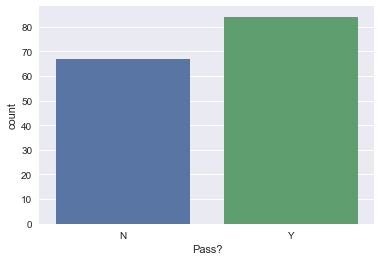

In [6]:
#Simple countplot for those films that passed the Bechdel test.
sns.countplot(x="Pass?", data=df)

#This pass rate is more than we would expect - cf other analyses on this topic done more in depth!

In [8]:
#Get a list of genres
genres = list(set([genre for genre in "|".join(df.iloc[:,1].tolist()).split("|")]))
genres

['Thriller',
 'Musical',
 'Drama',
 'Crime',
 'Comedy',
 'Mystery',
 'Western',
 'Adventure',
 'Fantasy',
 'War',
 'Horror',
 'Family',
 'Animation',
 'Sci-Fi',
 'Romance',
 'Action']

In [9]:
#We can analyse the percentage of films that passed by genre easily as seen below
genreBechdelTestdf = pd.DataFrame(0, index=np.arange(2), columns=genres)
for movie in range(0,len(df)):
    for genre in df.iloc[movie,1].split("|"):
        if df.iloc[movie,4] == ' Y' and df.iloc[movie,5] == ' Y':
            # The film of that genre passes the Bechdel Test
            genreBechdelTestdf.loc[1,genre] = genreBechdelTestdf.loc[1,genre] + 1  
        else:
            # The film of that genre foes not pass the Bechdel Test
            genreBechdelTestdf.loc[0,genre] = genreBechdelTestdf.loc[0,genre] + 1
            

In [10]:
genreBechdelTestdf

,Thriller,Musical,Drama,Crime,Comedy,Mystery,Western,Adventure,Fantasy,War,Horror,Family,Animation,Sci-Fi,Romance,Action
0,25,0,44,18,21,9,1,7,5,2,4,1,0,9,5,18
1,24,1,53,14,30,6,1,5,5,2,9,1,3,8,22,13


## Conclusion and Reflection
In my conclusions, it appeared around half of the films had scenes with two female characters present. I was unable to detect whether or not they were talking about a man but given this is a stronger condition this percentage would obviously be lower.
These results should be taken with a pinch of salt however, since there is a high misclassification error in the gender detection stage of my algorithm. If I had longer I would seek to call external API's or import some sort of baby book dictionary/csv file to look up genders or predict them with high probability, and use my algorithm only if this fails. I could also add in some basic catches like "MOTHER","FEMALE" etc were often miscategorised as "Male"; but this is more an indication that the *number of lines in which a female character is with a male character, and the focus is on the male character* is quite high, since the number of male pronouns used dominates the number of female pronouns used. This is, in a sense, capturing the inequality in cinema. I wasn't sure if you wanted me to try and use these more advanced techniques or just simply stick to what I could learn from the HTML itself. Unfortunately, since gender detection is a massive part of the accuracy of this algorithm, the results thereafter are somewhat infected. If I had a few more hours I would certainly look to refine this aspect.

We saw the analysis of Bechdel Test by Genre,and we can see that in Romances and Dramas, they have more females talking to each other in a scene than other films (as a percentage) and this roughly fits to what we would expect. It would be the case, probably, that in Romances they are often talking about a man, given the heteronormativity of cinema and the genre of the film.

However, when I started this project I had never used any of these techniques before (web scraping, RegEx) in Python, although I had heard of them/were familiar with them. This work was completed in around 8 hours, with an additional hour running the program and making the JuPyter Notebook look pretty. I used a variety of online resources including Youtube videos to learn how to do the techniques in this project. I hope this shows my capacity for learning as well as my coding ability.

There are many more things we can learn from this project in addition to what I have discussed here. I hope you find it as interesting as I did.

All the best,

Ryan